In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import tempfile
temp_dir = tempfile.TemporaryDirectory()
from casatasks import simobserve, tclean, exportfits
import os
import shutil
from casatools import table
from astropy.constants import c
from astropy.time import Time
import astropy.units as U
from martini.sources import TNGSource
from martini import DataCube, Martini
from martini.beams import GaussianBeam
from martini.noise import GaussianNoise
from martini.spectral_models import GaussianSpectrum
from martini.sph_kernels import AdaptiveKernel, GaussianKernel, CubicSplineKernel, DiracDeltaKernel
from natsort import natsorted
import math
from math import pi
from tqdm import tqdm
import time
from time import strftime, gmtime
import dask
from typing import Optional
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from random import choices

from spectral_cube import SpectralCube
import h5py
os.environ['MPLCONFIGDIR'] = temp_dir.name
pd.options.mode.chained_assignment = None  
def get_data_from_hdf(file):
    data = list()
    column_names = list()
    r = h5py.File(file, 'r')
    for key in r.keys():
        if key == 'Snapshot_99':
            group = r[key]
            for key2 in group.keys():
                column_names.append(key2)
                data.append(group[key2])
    values = np.array(data)
    db = pd.DataFrame(values.T, columns=column_names)     
    return db   

def load_fits(inFile):
    hdu_list = fits.open(inFile)
    data = hdu_list[0].data
    header = hdu_list[0].header
    hdu_list.close()
    return data, header

In [4]:
file = 'morphologies_deeplearn.hdf5'
db = get_data_from_hdf(file)
db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12535 entries, 0 to 12534
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P_Late      12535 non-null  float64
 1   P_S0        12535 non-null  float64
 2   P_Sab       12535 non-null  float64
 3   Sigma_Late  12535 non-null  float64
 4   Sigma_S0    12535 non-null  float64
 5   Sigma_Sab   12535 non-null  float64
 6   SubhaloID   12535 non-null  float64
dtypes: float64(7)
memory usage: 685.6 KB


In [49]:
catalogue = db[['SubhaloID', 'P_Late', 'P_S0', 'P_Sab']]
catalogue.sort_values(by=['P_Late'], inplace=True, ascending=False)
catalogue.head(10)
ellipticals = catalogue[(catalogue['P_Late'] > 0.6) & (catalogue['P_S0'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
lenticulars = catalogue[(catalogue['P_S0'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_Sab'] < 0.5)]
spirals = catalogue[(catalogue['P_Sab'] > 0.6) & (catalogue['P_Late'] < 0.5) & (catalogue['P_S0'] < 0.5)]

ellipticals['sum'] = ellipticals['P_S0'].values + ellipticals['P_Sab'].values
lenticulars['sum'] = lenticulars['P_Late'].values + lenticulars['P_Sab'].values

spirals['sum'] = spirals['P_Late'].values + spirals['P_S0'].values
ellipticals.sort_values(by=['sum'], inplace=True, ascending=True)
lenticulars.sort_values(by=['sum'], inplace=True, ascending=True)
spirals.sort_values(by=['sum'], inplace=True, ascending=True)
ellipticals_ids = ellipticals['SubhaloID'].values
lenticulars_ids = lenticulars['SubhaloID'].values
spirals_ids = spirals['SubhaloID'].values

print(len(ellipticals), len(lenticulars), len(spirals))
n = 100
sample_n = 100 // 3

n_0 = choices(ellipticals_ids, k=sample_n)
n_1 = choices(lenticulars_ids, k=sample_n)
n_2 = choices(spirals_ids, k=n - 2 * sample_n)
ids = np.concatenate((n_0, n_1, n_2))
print(len(ids))



117 1927 191
100


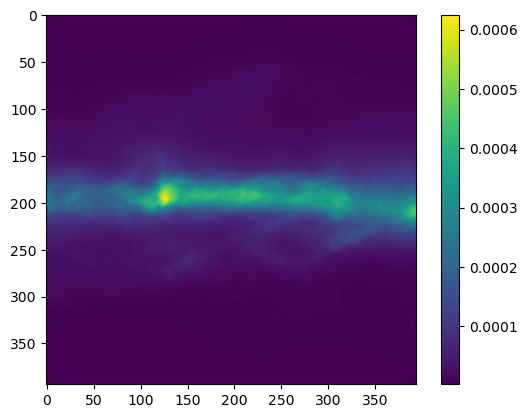

In [54]:
data_dir = '/media/storage/extended_sims_test_0'
extended, extended_header = load_fits(os.path.join(data_dir, 'skymodel_2.fits'))
#gaussian, gaussian_header = load_fits(os.path.join(data_dir, 'skymodel_1.fits'))
#print(extended.shape, gaussian.shape)


plt.imshow(np.sum(extended[0,:,:], axis=0))
plt.colorbar()
plt.show()
#plt.imshow(np.sum(gaussian[0,:,:], axis=0))
#plt.colorbar()
